## Import libararies

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import img_to_array
from IPython.display import clear_output, Video
import numpy as np
import time
import json
import cv2
import os
import wget

## Upload model

In [3]:
my_model = ResNet50(weights='artifacts/resnet50_weights_tf_dim_ordering_tf_kernels.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
with open("artifacts/imagenet_class_index.json", "r") as json_file:
    data = json.load(json_file)

## IoU for YOLO

In [5]:
def IoU(box1, box2):

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (yi2 - yi1) * (xi2 - xi1)

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    # compute the IoU
    return inter_area / union_area

## YOLO with OpenCV

In [6]:
class YOLO:
    def __init__(self, CONFIDENCE= 0.4, THRESHOLD= 0.2):
        self.CONFIDENCE = CONFIDENCE
        self.THRESHOLD = THRESHOLD

        # derive the paths to the YOLO weights and model configuration
        weightsPath ="artifacts/yolov3.weights"
        configPath = "artifacts/yolov3.cfg"

        # load YOLO object detector trained on COCO dataset (80 classes)
        net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

        # determine only the *output* layer names that we need from YOLO
        ln = net.getLayerNames()
        ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

        self.net = net
        self.ln = ln
    
    def forward(self, image):
        """
        feed an image to YOLO network, filter weak boxes, 
        return boxes, confidence, class labels
        """
        (H, W) = image.shape[:2]
        # construct a blob from the input image and then perform a forward
        # pass of the YOLO object detector, giving us our bounding boxes and
        # associated probabilities
        blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
        self.net.setInput(blob)
        start = time.time()
        layerOutputs = self.net.forward(self.ln)
        end = time.time()

#         print("[INFO] YOLO took {:.6f} seconds".format(end - start))

        # initialize our lists of detected bounding boxes, confidences, and
        # class IDs, respectively
        boxes = []
        confidences = []
        classIDs = []

        # loop over each of the layer outputs
        for output in layerOutputs:
          # loop over each of the detections
            for detection in output:
                # extract the class ID and confidence
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                # filter out weak predictions 
                if confidence > self.CONFIDENCE:
                    # scale the bounding box coordinates back relative to the
                    # size of the image, keeping in mind that YOLO actually
                    # returns the center (x, y)-coordinates of the bounding
                    # box followed by the boxes' width and height
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")

                    # use the center (x, y)-coordinates to derive the top and
                    # and left corner of the bounding box
                    x = int(centerX - (width / 2))
                    y = int(centerY + (height / 2))

                    # update our list of bounding box coordinates, confidences,
                    # and class IDs
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        self.boxes = np.array(boxes)
        self.confidences = np.array(confidences)
        self.classIDs = np.array(classIDs)
    
    def non_max_supression(self):
        """
        perform non-maximum supression over boxes
        """
        idxs = np.argsort(-self.confidences)
        confidences = self.confidences[idxs]
        boxes = self.boxes[idxs]
        classIDs = self.classIDs[idxs]

        for i in range(len(boxes)):
            x,y,w,h = boxes[i][0],  boxes[i][1], boxes[i][2], boxes[i][3]
            box1 = [x, y, x+w, y-h]
            for j in range(i+1, len(boxes)):
                if classIDs[i] == classIDs[j]:

                    # find iou between equal classes
                    x,y,w,h = boxes[j][0], boxes[j][1], boxes[j][2], boxes[j][3]
                    box2 = [x, y, x+w, y-h]
                    if IoU(box1, box2)>self.THRESHOLD:
                        confidences[j] = 0


        idxs = np.where(confidences>0)

        self.boxes = boxes[idxs]
        self.confidences = confidences[idxs]
        self.classIDs = classIDs[idxs]
  
  
    def crop_image(self, a, image):
        return image[max(a[3],0):min(a[1], image.shape[0]),max(a[0],0):min(a[2], image.shape[1]),:]


    def detect(self, image):
        """
        detect objects, supress non maximums, draw boxes
        return image with boxes
        """
        self.forward(image)
        self.non_max_supression()
        rect = []
        dogs = []
        for i in range(len(self.boxes)):
            if  self.classIDs[i] > 16 or   self.classIDs[i] < 15:
                continue
           
            # extract the bounding box coordinates
            (x, y) = (self.boxes[i][0], self.boxes[i][1])
            (w, h) = (self.boxes[i][2], self.boxes[i][3])
            # cut part
            cut = self.crop_image((x, y, x + w, y - h), image)
            dogs.append(cv2.cvtColor(cut, cv2.COLOR_BGR2RGB))
            rect.append(((x,y),(x+w,y-h)))

          # classification
        if len(dogs) == 0:
            return image
        img_array = np.array([img_to_array(cv2.resize(img, (224,224))) for img in dogs])
        output = preprocess_input(img_array)
        preds = my_model.predict(output)

        for i in range(len(preds)):
            #get best pred

            m = np.argmax(preds[i])
        
            if preds[i][m] < 0.5:
                label = 'dog '+str(preds[i][m])
            else:
                label = data[str(m)][1]+' '+str(preds[i][m])

          # draw a bounding box rectangle and label on the image

            cv2.rectangle(image, rect[i][0], rect[i][1], (255,0,0), 2)
            cv2.putText(image, label, (rect[i][0][0], rect[i][1][1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
        return image


In [7]:
yolo = YOLO()

In [8]:
def video_detect_dogs_breed(video, name="dog.avi"):
    writer = None
    (W, H) = (None, None)
    i = 0
    while True:

        # read the next frame
        (grabbed, frame) = video.read()
        i += 1
        if i % 1 == 0:
            
            # check grabbed
            if not grabbed:
                break

            # get size of  video frame
            if W is None or H is None:
                (H, W) = frame.shape[:2]

            # detect frame 
            frame = yolo.detect(frame)

            # if writer is None then initialize new video writer
            if writer is None:
                file_name = "content/video/new_"+name.split('.')[0]+'.avi'
                writer = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*"MJPG"), 6,(W, H), True)
            
            # write to disk
            writer.write(frame)

            plt.figure(figsize=(25,25))
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            clear_output()
            plt.show()
    return writer


In [9]:
def image_detecting(name):
    name = 'content/image/'+name
    new_name = 'content/image/new_'+name
    # wget.download('https://sun9-54.userapi.com/c855724/v855724576/122f95/wIeDBkphaxw.jpg', name)
    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    start= time.time()
    image = yolo.detect(image)
    print(f"Total time: {time.time()-start}")
    cv2.imwrite(new_name,image)
    plt.figure(figsize=(25,25))
    plt.imshow(image)
    plt.show()

In [10]:
def video_detecting(name):
    video = cv2.VideoCapture('content/video/'+name)
    video_detect_dogs_breed(video, name).release()

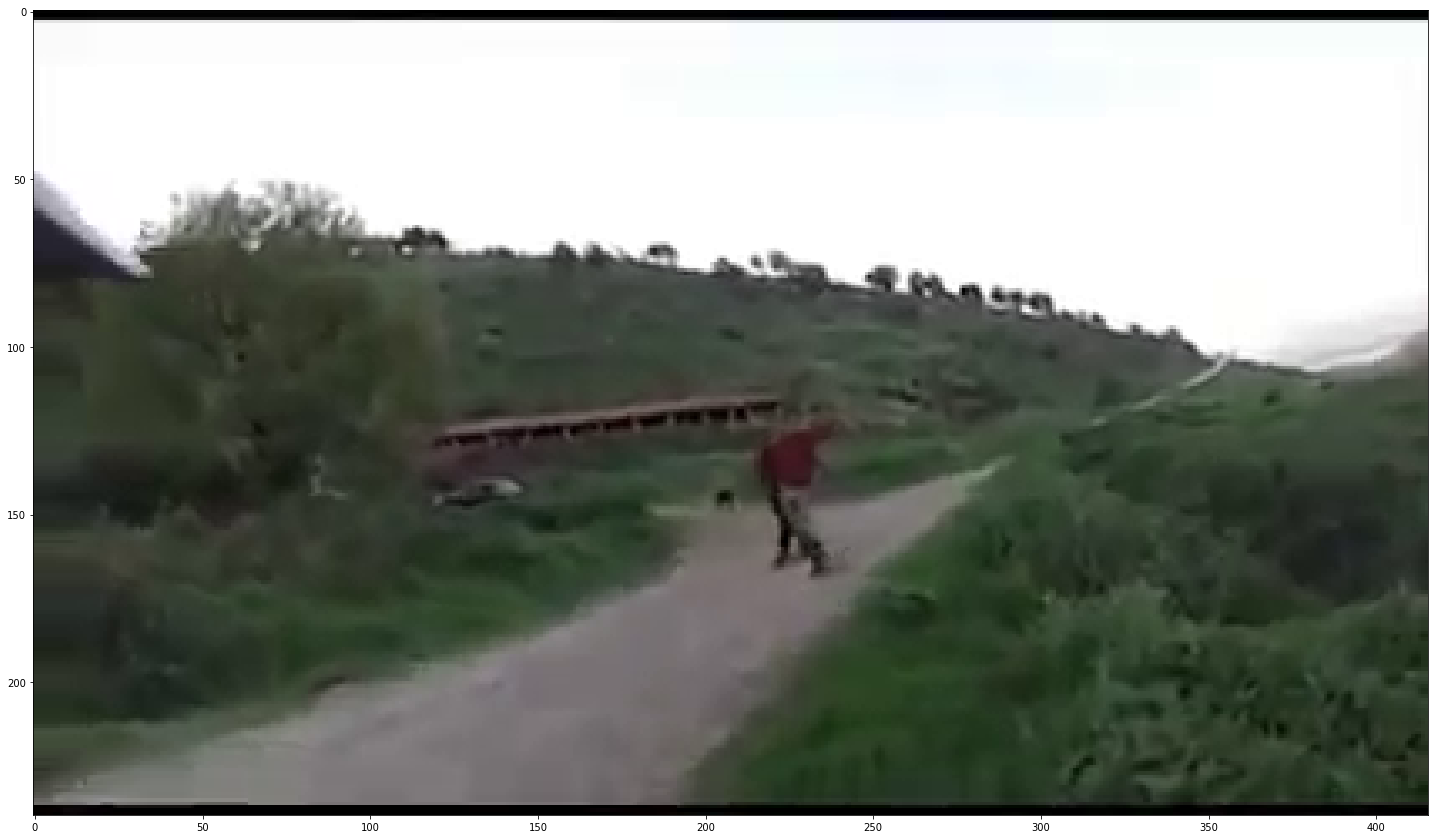

In [11]:
video_detecting("dogs_byke.mp4")

[INFO] YOLO took 1.341999 seconds
Total time: 1.9449958801269531


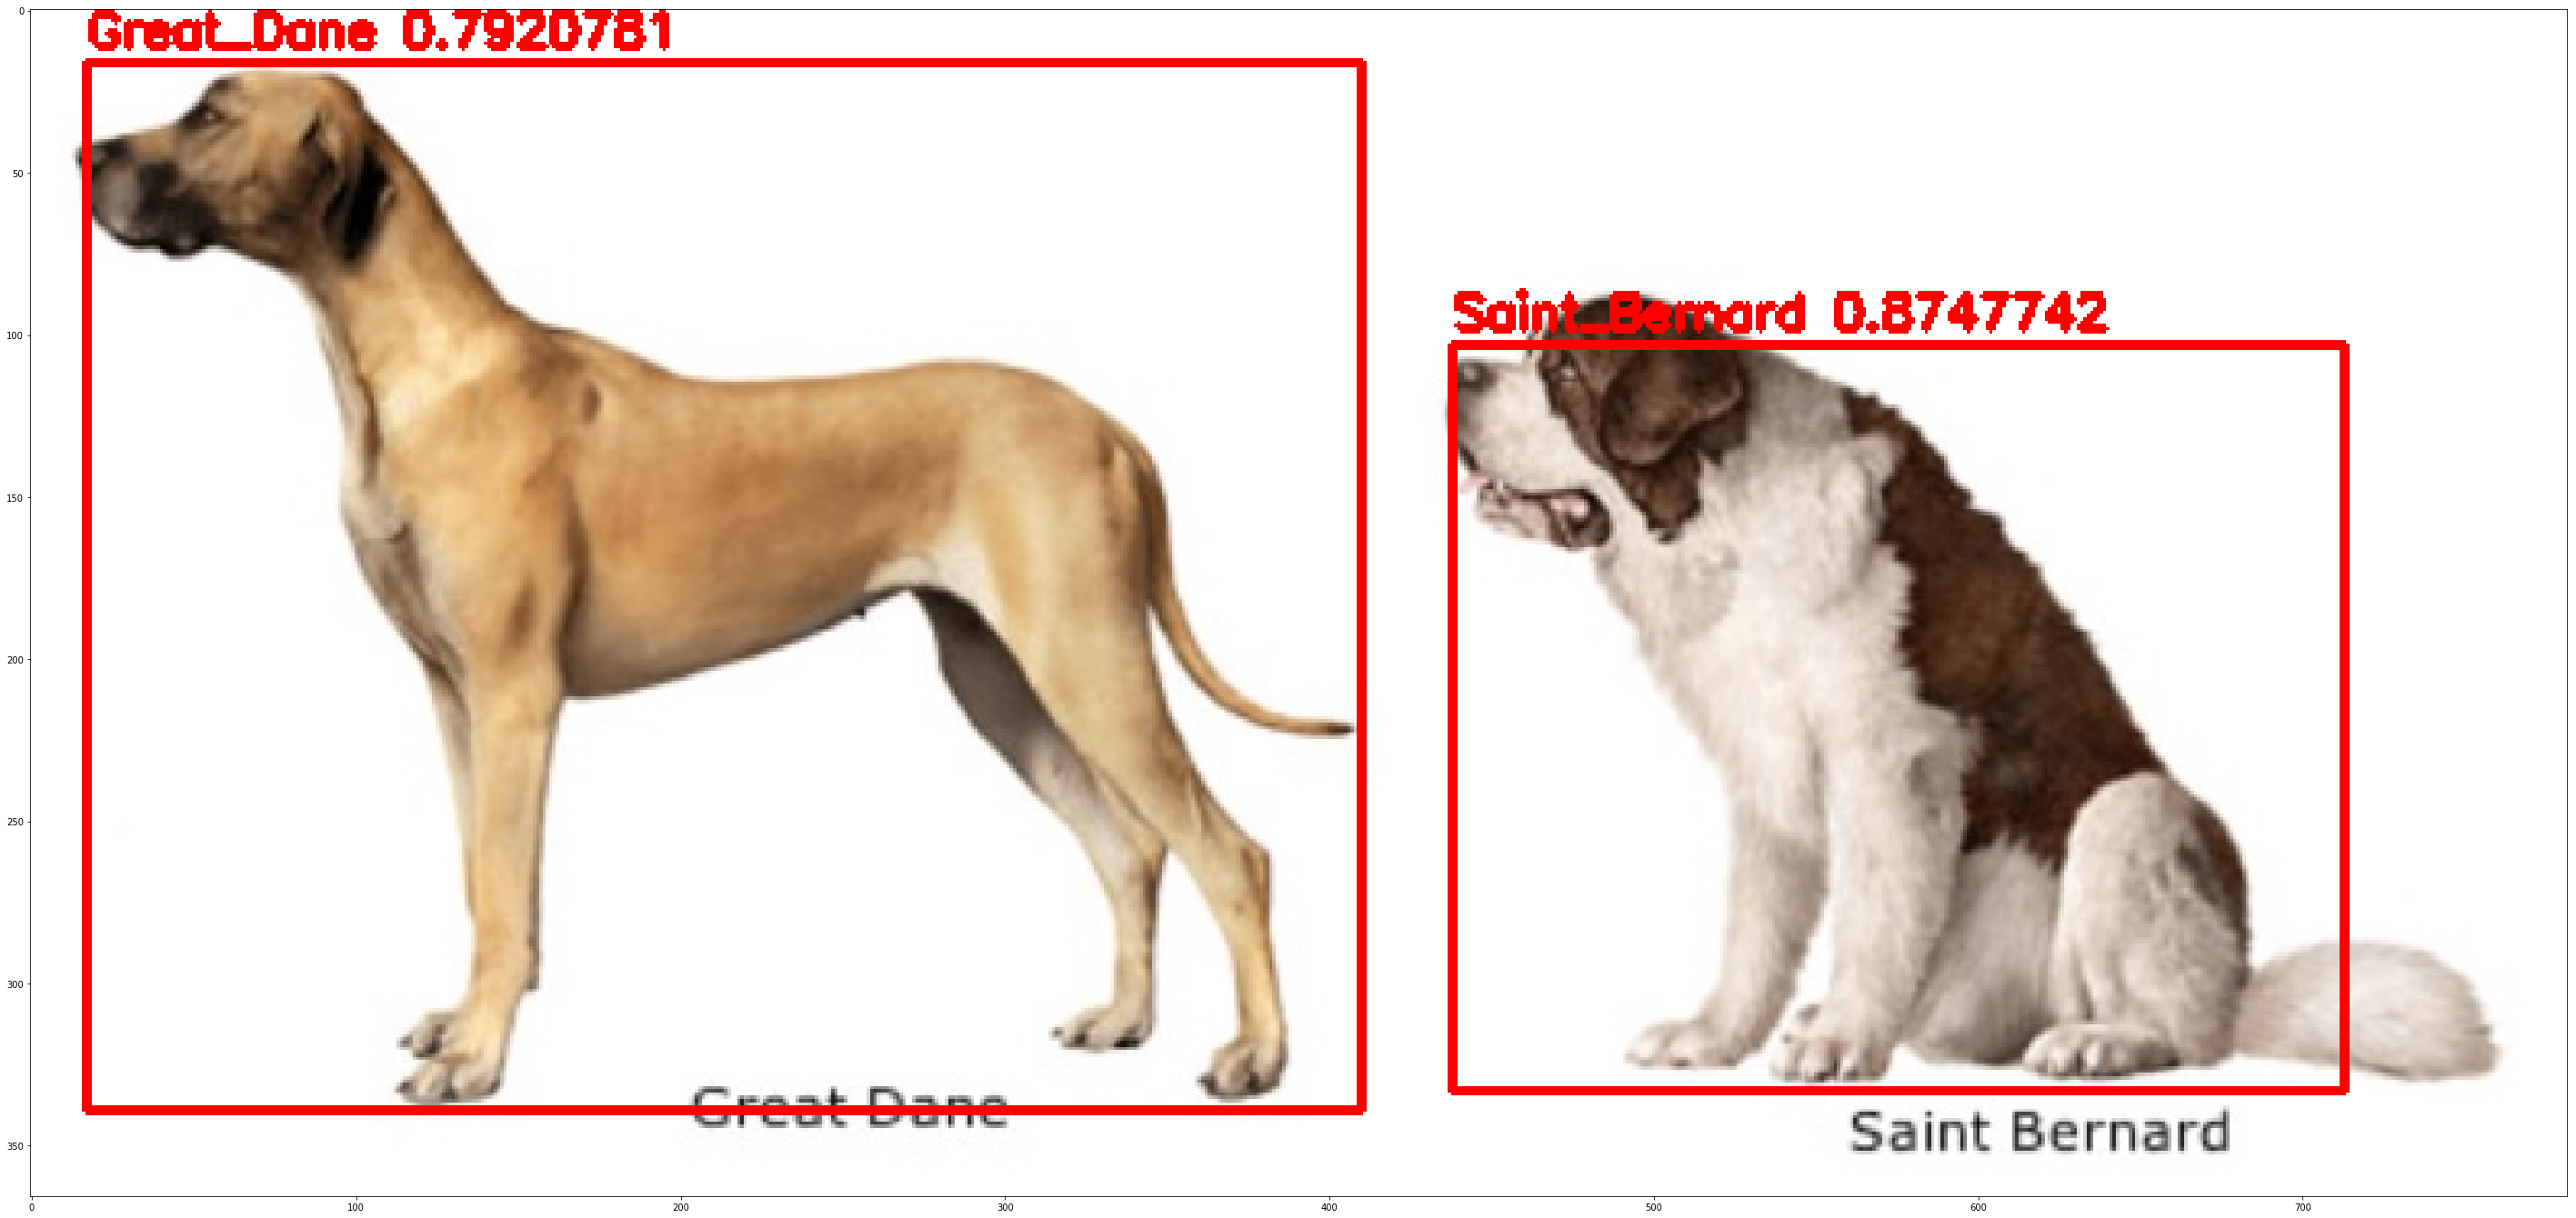

In [17]:
image_detecting('dogs_2.jpg')

In [ ]:
image_detecting('dogs_2.jpg')